# TOX24 Challenge

https://ochem.eu/static/challenge.do

### Goal 
Tox24 Challenge is designed to assess the progress in computational methods for predicting in vitro activity of compounds. The development of these methods has steadily gained momentum.

### Data
The chemicals and compounds being tested for activity against Transthyretin (TTR) within the “Toxicology in the 21st Century” (Tox21) initiative by the EPA will be used as the training and test sets for the Tox24 challenge. The initial dataset has been split into a training set (1012 compounds), a leaderboard set (200 compounds) and a blind set (300 compounds).

Refer `TOX - EDA.ipynb` for EDA

### QSPR Models 

In [1]:
#import
import numpy as np
import pandas as pd
from rdkit import Chem
import seaborn as sns
import matplotlib.pyplot as plt
from rdkit.Chem import Descriptors, rdMolDescriptors, AllChem, DataStructs

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.model_selection import cross_val_score, cross_val_predict, KFold
from sklearn.metrics import mean_squared_error, r2_score

## XGBOOST - Descriptors

In [2]:
def generate_2d_descriptors(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None
    return {desc_name: func(mol) for desc_name, func in Descriptors.descList}

In [3]:
def generate_3d_descriptors(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None 
    mol = Chem.AddHs(mol)  

    try:
        AllChem.EmbedMolecule(mol, AllChem.ETKDG())
        AllChem.UFFOptimizeMolecule(mol)

        descriptors_3d = {
            "radius_of_gyration": rdMolDescriptors.CalcRadiusOfGyration(mol),
            "asphericity": rdMolDescriptors.CalcAsphericity(mol),
            "spherocity_index": rdMolDescriptors.CalcSpherocityIndex(mol),
            "eccentricity": rdMolDescriptors.CalcEccentricity(mol),
            "NPR1": rdMolDescriptors.CalcNPR1(mol),
            "NPR2": rdMolDescriptors.CalcNPR2(mol),
            "PMI1": rdMolDescriptors.CalcPMI1(mol),
            "PMI2": rdMolDescriptors.CalcPMI2(mol),
            "PMI3": rdMolDescriptors.CalcPMI3(mol),
        }

        return descriptors_3d

    except:
        return None 

In [4]:
datafile = pd.read_csv("tox24_challenge_train.csv")

In [5]:
smiles_list = datafile["SMILES"].to_list()
activity_values = datafile["activity"].to_list()

In [6]:
data = []
for smiles in smiles_list:
    descriptors_2d = generate_2d_descriptors(smiles)
    descriptors_3d = generate_3d_descriptors(smiles)

    if descriptors_2d and descriptors_3d:
        combined_descriptors = {**descriptors_2d, **descriptors_3d}
        combined_descriptors["SMILES"] = smiles
        data.append(combined_descriptors)

[20:25:38] UFFTYPER: Unrecognized atom type: Ca1+2 (0)
[20:25:38] UFFTYPER: Unrecognized atom type: Ca+2 (0)
[20:25:38] UFFTYPER: Unrecognized atom type: Ca1+2 (0)
[20:25:38] UFFTYPER: Unrecognized atom type: Ca+2 (1)
[20:25:44] UFFTYPER: Unrecognized atom type: Ca+2 (0)
[20:25:44] UFFTYPER: Unrecognized atom type: Ca+2 (0)
[20:25:47] UFFTYPER: Unrecognized atom type: Co3+3 (0)
[20:25:47] UFFTYPER: Unrecognized atom type: Co3+3 (0)
[20:25:47] UFFTYPER: Unrecognized atom type: Co3+3 (0)
[20:25:47] UFFTYPER: Unrecognized atom type: Co3+3 (0)
[20:25:47] UFFTYPER: Unrecognized atom type: Co3+3 (0)
[20:25:47] UFFTYPER: Unrecognized atom type: Co3+3 (0)
[20:25:47] UFFTYPER: Unrecognized atom type: Co3+3 (0)
[20:25:47] UFFTYPER: Unrecognized atom type: Co3+3 (0)
[20:25:47] UFFTYPER: Unrecognized atom type: Co3+3 (0)
[20:25:47] UFFTYPER: Unrecognized atom type: Co3+3 (0)
[20:25:47] UFFTYPER: Unrecognized atom type: Co3+3 (0)
[20:25:47] UFFTYPER: Unrecognized atom type: Co3+3 (0)
[20:25:47] UFF

In [7]:
df = pd.DataFrame(data)

In [8]:
data = datafile.merge(df,on="SMILES").drop_duplicates()

In [9]:
data.columns

Index(['SMILES', 'activity', 'MaxAbsEStateIndex', 'MaxEStateIndex',
       'MinAbsEStateIndex', 'MinEStateIndex', 'qed', 'SPS', 'MolWt',
       'HeavyAtomMolWt',
       ...
       'fr_urea', 'radius_of_gyration', 'asphericity', 'spherocity_index',
       'eccentricity', 'NPR1', 'NPR2', 'PMI1', 'PMI2', 'PMI3'],
      dtype='object', length=221)

In [10]:
cor = abs(data.corr()["activity"])

C:\Users\shasa\AppData\Local\Temp\ipykernel_23112\3962194765.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  cor = abs(data.corr()["activity"])


C:\Users\shasa\AppData\Local\Temp\ipykernel_23112\967887815.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  plt.plot(abs(data.corr()["activity"]))


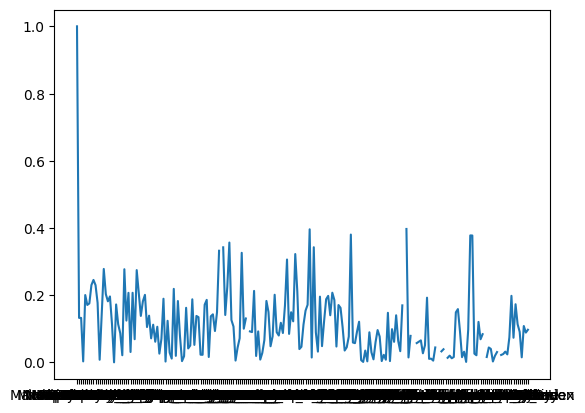

In [11]:
plt.plot(abs(data.corr()["activity"]))

### XGBOOST Regressor

In [12]:
final = data[cor[cor>0.2].index]
#final = data.copy()

In [13]:
#final["SMILES"] = data["SMILES"]

In [14]:
final.columns

Index(['activity', 'MinEStateIndex', 'MolWt', 'HeavyAtomMolWt', 'ExactMolWt',
       'MinPartialCharge', 'MaxAbsPartialCharge', 'BCUT2D_LOGPHI',
       'BCUT2D_MRHI', 'AvgIpc', 'BertzCT', 'Chi0', 'Chi1', 'LabuteASA',
       'SMR_VSA7', 'SMR_VSA9', 'SlogP_VSA10', 'SlogP_VSA11', 'SlogP_VSA6',
       'EState_VSA10', 'VSA_EState1', 'VSA_EState6', 'FractionCSP3',
       'HeavyAtomCount', 'NumAromaticCarbocycles', 'NumAromaticRings',
       'MolLogP', 'fr_Ar_OH', 'fr_benzene', 'fr_phenol',
       'fr_phenol_noOrthoHbond'],
      dtype='object')

In [15]:
final.shape

(1005, 31)

In [16]:
#final.drop('SMILES', axis=1,inplace=True)

In [17]:
scaler = MinMaxScaler() #scaling
final_scale = pd.DataFrame(scaler.fit_transform(final.drop('activity', axis=1)),columns=final.columns.to_list()[1:])

In [18]:
X = final_scale
y = final['activity']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [19]:
model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42)

In [20]:
cv = KFold(n_splits=5, shuffle=True, random_state=42)
y_pred_cv = cross_val_predict(model, X_train, y_train, cv=cv)
rmse = np.sqrt(mean_squared_error(y_train, y_pred_cv))
r2 = r2_score(y_train, y_pred_cv)

print(f'Cross-Validation RMSE: {rmse:.4f}')
print(f'Cross-Validation R²: {r2:.4f}')

Cross-Validation RMSE: 28.4709
Cross-Validation R²: 0.3662


In [21]:
model.fit(X_train, y_train)

y_pred_test = model.predict(X_test)
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
r2_test = r2_score(y_test, y_pred_test)

print(f'Test RMSE: {rmse_test:.4f}')
print(f'Test R²: {r2_test:.4f}')

Test RMSE: 27.8346
Test R²: 0.4562


In [22]:
idx = model.feature_importances_.argsort()

<BarContainer object of 10 artists>

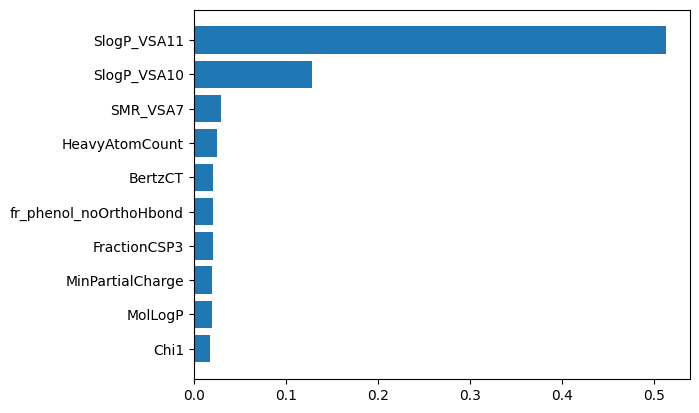

In [23]:
plt.barh(X_train.columns[idx][20:30],model.feature_importances_[idx][20:30])

## NN - Fingerprint

In [24]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

In [25]:
def elastic_net_loss(output, target, model, l1_lambda, l2_lambda):
    mse_loss = nn.MSELoss()(output, target)  
    
    l1_penalty = sum(p.abs().sum() for p in model.parameters())  
    l2_penalty = sum((p ** 2).sum() for p in model.parameters()) 
    
    return mse_loss + l1_lambda * l1_penalty + l2_lambda * l2_penalty

In [26]:
class NNRegressor(nn.Module):
    def __init__(self, input_dim, hidden_dim1, hidden_dim2, hidden_dim3,hidden_dim4, dropout_rate):
        super(NNRegressor, self).__init__()
        
        self.fc1 = nn.Linear(input_dim, hidden_dim1)
        self.fc2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.fc3 = nn.Linear(hidden_dim2, hidden_dim3) 
        self.fc4 = nn.Linear(hidden_dim3, hidden_dim4) 
        self.fc5 = nn.Linear(hidden_dim4, 1)
        
        self.relu = nn.LeakyReLU()
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.fc2(x)
        x = self.relu(x)
        x = self.dropout(x)

        x = self.fc3(x)
        x = self.relu(x)
        x = self.dropout(x)

        x = self.fc4(x)
        x = self.relu(x)
        x = self.dropout(x)

        x = self.fc5(x)
        return x 

class RMSELoss(nn.Module):
    def __init__(self):
        super(RMSELoss, self).__init__()
        self.mse = nn.MSELoss()

    def forward(self, y_pred, y_true):
        return torch.sqrt(self.mse(y_pred, y_true))

class NNDataset(Dataset):
    def __init__(self, df, label_column):
        self.embeddings = torch.tensor(df.drop(columns=[label_column]).values, dtype=torch.float32)
        self.labels = torch.tensor(df[label_column].values, dtype=torch.float32).unsqueeze(1) 

    def __len__(self):
        return len(self.embeddings)

    def __getitem__(self, idx):
        return self.embeddings[idx], self.labels[idx]

In [27]:
def train_model(model, data_loader, optimizer, l1_lambda, l2_lambda, epochs):
    model.train()
    for epoch in range(epochs):
        epoch_loss = 0
        for inputs, targets in data_loader:
            
            optimizer.zero_grad()
            outputs = model(inputs)
            
            # Compute elastic net loss
            loss = elastic_net_loss(outputs, targets, model, l1_lambda, l2_lambda)
            
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
        
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {epoch_loss / len(data_loader):.4f}")

In [28]:
def evaluate_model(model, data_loader, l1_lambda, l2_lambda):
    model.eval()
    all_preds = []
    all_labels = []
    total_loss = 0

    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            
            # Compute standard MSE loss
            mse_loss = nn.MSELoss()(outputs, labels)

            # Compute L1 + L2 regularization terms
            l1_penalty = sum(p.abs().sum() for p in model.parameters())
            l2_penalty = sum((p ** 2).sum() for p in model.parameters())

            # Compute total loss
            loss = mse_loss + l1_lambda * l1_penalty + l2_lambda * l2_penalty
            total_loss += loss.item()

            all_preds.extend(outputs.cpu().numpy().flatten())
            all_labels.extend(labels.cpu().numpy().flatten())

    # Compute RMSE
    rmse = np.sqrt(mean_squared_error(all_labels, all_preds))
    print(f"Test RMSE Loss: {rmse:.4f}")

    # Compute R² score
    r2_test = r2_score(all_labels, all_preds)
    print(f"Test R²: {r2_test:.4f}")

    # Plot True vs Predicted values
    plt.figure(figsize=(6, 5))
    plt.scatter(all_labels, all_preds, alpha=0.5)
    plt.plot([min(all_labels), max(all_labels)], [min(all_labels), max(all_labels)], color='red')
    plt.xlabel("True Values")
    plt.ylabel("Predicted Values")
    plt.title("True vs Predicted Values")
    plt.show()

In [29]:
import pandas as pd

In [30]:
datafile = pd.read_csv("tox24_challenge_train.csv")

In [31]:
smiles_list = datafile["SMILES"].to_list()
activity_values = datafile["activity"].to_list()

In [315]:
def smiles_to_fingerprint(smiles, radius=1, n_bits=2048):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits=n_bits)
    arr = np.zeros((1,), dtype=np.int8)
    DataStructs.ConvertToNumpyArray(fp, arr)
    return arr

In [316]:
fingerprints = np.array([smiles_to_fingerprint(s) for s in smiles_list if smiles_to_fingerprint(s) is not None])

[02:46:42] DEPRECATION WARNING: please use MorganGenerator
[02:46:42] DEPRECATION WARNING: please use MorganGenerator
[02:46:42] DEPRECATION WARNING: please use MorganGenerator
[02:46:42] DEPRECATION WARNING: please use MorganGenerator
[02:46:42] DEPRECATION WARNING: please use MorganGenerator
[02:46:42] DEPRECATION WARNING: please use MorganGenerator
[02:46:42] DEPRECATION WARNING: please use MorganGenerator
[02:46:42] DEPRECATION WARNING: please use MorganGenerator
[02:46:42] DEPRECATION WARNING: please use MorganGenerator
[02:46:42] DEPRECATION WARNING: please use MorganGenerator
[02:46:42] DEPRECATION WARNING: please use MorganGenerator
[02:46:42] DEPRECATION WARNING: please use MorganGenerator
[02:46:42] DEPRECATION WARNING: please use MorganGenerator
[02:46:42] DEPRECATION WARNING: please use MorganGenerator
[02:46:42] DEPRECATION WARNING: please use MorganGenerator
[02:46:42] DEPRECATION WARNING: please use MorganGenerator
[02:46:42] DEPRECATION WARNING: please use MorganGenerat

In [317]:
final2 = pd.concat([datafile,pd.DataFrame(fingerprints)],axis=1).drop("SMILES",axis=1)

In [318]:
#final2 = final2[final2["activity"]>=-20]
#final2 = final2[final2["activity"]>=0]

In [323]:
input_dim = 2048
hidden_dim1 = 2048*2
hidden_dim2 = 1024*3
hidden_dim3 = 1024
hidden_dim4 = 500
dropout_rate = 0.5
epochs = 100

model = NNRegressor(input_dim, hidden_dim1, hidden_dim2, hidden_dim3, hidden_dim4, dropout_rate)
criterion = RMSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

l1_lambda = 0
l2_lambda = 0.01

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

label_column = "activity"
train_df, test_df = train_test_split(final2, test_size=0.3, random_state=42)

train_dataset = NNDataset(train_df, label_column)
train_loader = DataLoader(train_dataset, batch_size=500, shuffle=True)

test_dataset = NNDataset(test_df, label_column)
test_loader = DataLoader(test_dataset, batch_size=500, shuffle=True)

best_loss = float("inf")
best_model_state = None

for epoch in range(epochs):
    model.train()
    train_loss = 0.0

    for batch in train_loader:
        inputs, targets = batch
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        
        # Compute loss with L1 regularization
        l1_reg = sum(p.abs().sum() for p in model.parameters())
        loss = criterion(outputs, targets) + l1_lambda * l1_reg

        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    avg_train_loss = train_loss / len(train_loader)

    # Save best model
    if avg_train_loss < best_loss:
        best_loss = avg_train_loss
        best_model_state = model.state_dict()

    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss:.4f}")

# Load the best model
model.load_state_dict(best_model_state)
print(f"Best model loaded with Train Loss: {best_loss:.4f}")

Epoch 1/100, Train Loss: 53.5202
Epoch 2/100, Train Loss: 52.2736
Epoch 3/100, Train Loss: 52.2308
Epoch 4/100, Train Loss: 52.9282
Epoch 5/100, Train Loss: 53.2344
Epoch 6/100, Train Loss: 53.1904
Epoch 7/100, Train Loss: 53.0524
Epoch 8/100, Train Loss: 51.2848
Epoch 9/100, Train Loss: 50.3402
Epoch 10/100, Train Loss: 48.8681
Epoch 11/100, Train Loss: 46.8663
Epoch 12/100, Train Loss: 44.6488
Epoch 13/100, Train Loss: 41.1196
Epoch 14/100, Train Loss: 37.8322
Epoch 15/100, Train Loss: 36.5371
Epoch 16/100, Train Loss: 36.8660
Epoch 17/100, Train Loss: 37.0097
Epoch 18/100, Train Loss: 35.3961
Epoch 19/100, Train Loss: 33.9368
Epoch 20/100, Train Loss: 32.8462
Epoch 21/100, Train Loss: 32.6299
Epoch 22/100, Train Loss: 32.6891
Epoch 23/100, Train Loss: 31.7897
Epoch 24/100, Train Loss: 30.9638
Epoch 25/100, Train Loss: 29.5666
Epoch 26/100, Train Loss: 30.5381
Epoch 27/100, Train Loss: 28.9384
Epoch 28/100, Train Loss: 29.1049
Epoch 29/100, Train Loss: 28.7693
Epoch 30/100, Train Los

Test RMSE Loss: 28.9533
Test R²: 0.4100


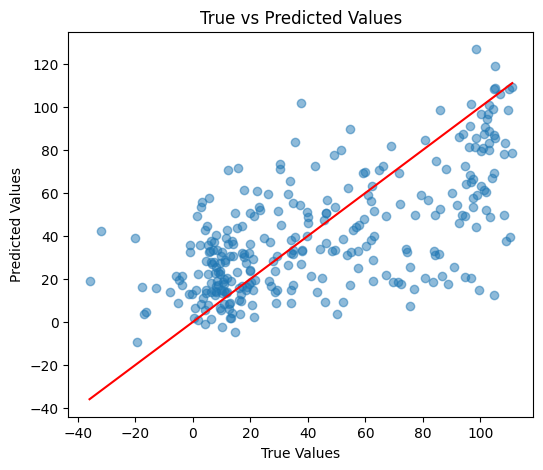

In [324]:
evaluate_model(model, test_loader, l1_lambda, l2_lambda)